<a href="https://colab.research.google.com/github/karank85/speech-recognition/blob/main/training_notebook_non_dl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

import numpy as np
from numpy import ndarray
import pandas as pd
import random

import librosa

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa.display

from tqdm import tqdm

import tqdm

import glob
import torch

from pathlib import Path

In [ ]:
librosa.__version__

'0.10.1'

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
# Assumptions:
# - The transcription file is located in the same directory as the audio files.
class AudioDataset:
  """
  Class for loading and storing audio data.
  """

  def __init__(self):
    self.df = pd.DataFrame(columns=['id', 'path', 'transcription'])

  def load_transcriptions(self, directory_path: str) -> bool:
    """
    Load all transcriptions from a given directory, including subdirectories.
    Returns False if no transcription files were found, or if any failed to load.
    """
    sound_names = glob.glob(
        f"{directory_path}/**/*.wav",
        recursive=True
    )

    if len(sound_names) == 0:
      return False

    for path in sound_names:
      if not self.load_transcription_file(path):
        return False

    return True



  def load_transcription_file(self, file_path: str) -> bool:
    """
    Parse transcription file and records the audio ID - subtitle mapping.
    Returns False if the file could not be read.
    """

    file_directory = Path(file_path).parent
    file_name = Path(file_path).stem
    self.df.loc[len(self.df)] = {
        'id':file_name,
        'transcription':file_directory.name,
        'path': f'{file_directory}/{file_name}.wav'
    }
    return True

  def keys(self):
    return iter(self.df['id'])

  def get(self, id: int):
    """
    Retrieve a dataframe row from ID.
    """
    return self.df.loc[self.df['id'] == id]

In [ ]:
random.seed(42)

def split_dataframe(df, ratio):
    # Shuffle the DataFrame
    df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

    # Calculate the split index
    split_index = int(len(df_shuffled) * ratio)

    # Split the DataFrame
    # df_1 = df_shuffled.iloc[:split_index]
    df_2 = df_shuffled.iloc[split_index:] # unneeded for training

    return df_2

In [ ]:
df_dict = {}

In [ ]:
all_subdirectories = glob.glob(
        f"/content/drive/MyDrive/datasets/single_words/*",
        recursive=True
)

for i in tqdm.tqdm(range(len(all_subdirectories))):
  path = all_subdirectories[i]
  fruit_label = Path(path).name
  ds = AudioDataset()
  if ds.load_transcriptions(path):
    df_dict[fruit_label] = split_dataframe(ds.df, 0.8)

100%|██████████| 30/30 [01:20<00:00,  2.70s/it]


In [ ]:
df_dict

{'bed':         id                                               path transcription
 0     1539  /content/drive/MyDrive/datasets/single_words/b...           bed
 1      118  /content/drive/MyDrive/datasets/single_words/b...           bed
 2     1452  /content/drive/MyDrive/datasets/single_words/b...           bed
 3      342  /content/drive/MyDrive/datasets/single_words/b...           bed
 4      869  /content/drive/MyDrive/datasets/single_words/b...           bed
 ...    ...                                                ...           ...
 1080   218  /content/drive/MyDrive/datasets/single_words/b...           bed
 1081   252  /content/drive/MyDrive/datasets/single_words/b...           bed
 1082  1176  /content/drive/MyDrive/datasets/single_words/b...           bed
 1083  1194  /content/drive/MyDrive/datasets/single_words/b...           bed
 1084  1203  /content/drive/MyDrive/datasets/single_words/b...           bed
 
 [1085 rows x 3 columns],
 'bird':         id                      

In [ ]:
sample_df = df_dict['bed']
sample_input_file = sample_df['path'].iloc[0]
print("Selected input file: ", sample_input_file)

Selected input file:  /content/drive/MyDrive/datasets/single_words/bed/1539.wav


<Axes: title={'center': 'Audio signal'}, xlabel='Time', ylabel='Amplitude'>

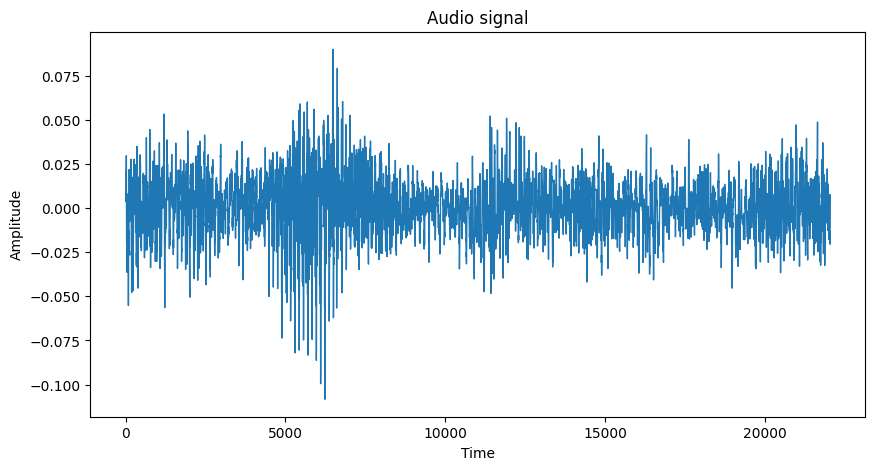

In [ ]:
audio, sampling_freq = librosa.load(sample_input_file)
pd.Series(audio).plot(figsize=(10, 5),lw=1, title="Audio signal", xlabel="Time", ylabel="Amplitude")

Text(0.5, 1.0, 'Power Spectrum')

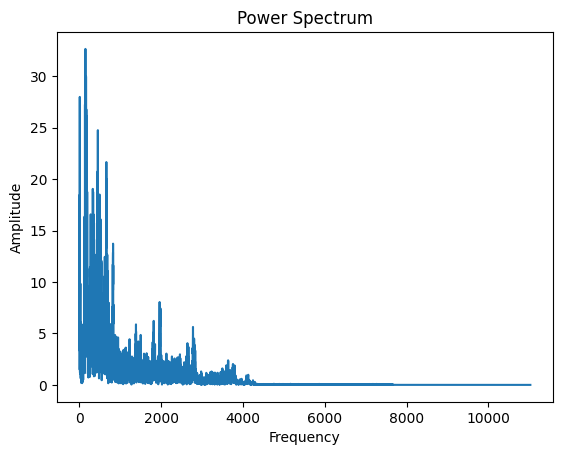

In [ ]:
fft = np.fft.fft(audio)

magnitude = np.abs(fft)
frequency = np.linspace(0, sampling_freq, len(magnitude))

left_freq = frequency[:int(len(frequency)/2)]
left_mag = magnitude[:int(len(frequency)/2)]

plt.plot(left_freq, left_mag)
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.title("Power Spectrum")

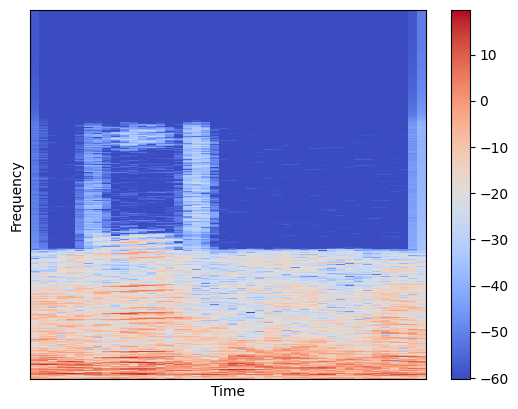

In [ ]:
n_fft = 2048
hop_length = 512

stft = librosa.core.stft(audio, hop_length=hop_length, n_fft=n_fft)
spectrogram = np.abs(stft)

log_spectrogram = librosa.amplitude_to_db(spectrogram)

librosa.display.specshow(log_spectrogram, sr=sampling_freq, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()


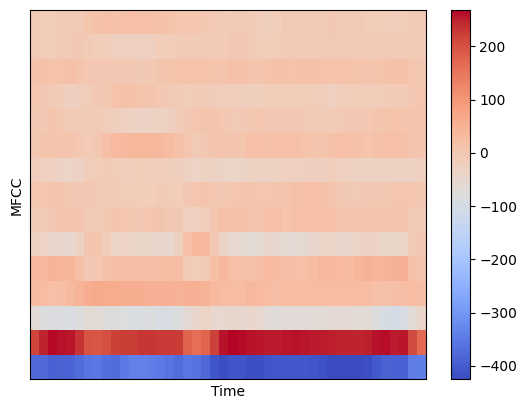

In [ ]:
mfccs = librosa.feature.mfcc(y=audio, n_fft=n_fft, hop_length=hop_length, n_mfcc=15)
librosa.display.specshow(mfccs, sr=sampling_freq, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC")
plt.colorbar()
plt.show()

### Extracting Features

In [ ]:
# from librosa.feature import mfcc
# import librosa
# audio, sampling_freq = librosa.load(ds.df.head()['path'].values[0])
# mfcc_features = librosa.feature.mfcc(sr=sampling_freq, y=audio)
# print('\nNumber of windows =', mfcc_features.shape[0])
# print('Length of each feature =', mfcc_features.shape[1])

In [ ]:
# mfcc_features = mfcc_features.T
# plt.matshow(mfcc_features)
# plt.title('MFCC')

In [ ]:
!pip install hmmlearn
!pip install features

In [ ]:
import os
import numpy as np
from scipy.io import wavfile
from hmmlearn import hmm #importing GaussianHMM
import librosa # reading wavefilesfrom librosa.feature import mfcc #to extract mfcc features

In [ ]:
class HMMTrainer(object):
  def __init__(self, model_name='GaussianHMM', n_components=4):
     self.model_name = model_name
     self.n_components = n_components

     self.models = []
     if self.model_name == 'GaussianHMM':
        self.model=hmm.GaussianHMM(n_components=4)
     else:
        print("Please choose GaussianHMM")

  def train(self, X):
      self.models.append(self.model.fit(X))

  def get_score(self, input_data):
      return self.model.score(input_data)

In [ ]:
# We split the datasets into 2 part to increase the training process.
# Can find the full model for HMM in github name hmm_model.pkl
hmm_models = []

items = list(df_dict.items())
CAP = len(items)
MID_POINT = CAP // 2


items = list(df_dict.items())
for i in tqdm.tqdm(range(MID_POINT, CAP)):
  df = items[i]
  fruit_label = df[0]
  X = np.array([])
  for index, row in df[1].head(250).iterrows():
    # Read the input file
    audio, sampling_freq = librosa.load(row['path'])
    # Extract MFCC features
    mfcc_features = librosa.feature.mfcc(sr=sampling_freq, y=audio)
    # Append to the variable X
    if len(X) == 0:
      X = mfcc_features[:, :15]  # 15 here denotes the number of MFCC coefficients to consider
    else:
      X = np.append(X, mfcc_features[:, :15], axis=0)
    # Append the label
    # print('X.shape =', X.shape)

  # Train HMM model for this iteration
  hmm_trainer = HMMTrainer()
  hmm_trainer.train(X)  # Train using the current MFCC features
  hmm_models.append((hmm_trainer, fruit_label))


100%|██████████| 15/15 [22:20<00:00, 89.38s/it]


In [ ]:
from joblib import Parallel, delayed
import multiprocessing

def train_model(num: int):
  items = list(df_dict.items())
  for i in tqdm.tqdm(range(MID_POINT, CAP)):
    df = items[i]
    fruit_label = df[0]
    X = np.array([])
    for index, row in df[1].head(250).iterrows():
      # Read the input file
      audio, sampling_freq = librosa.load(row['path'])
      # Extract MFCC features
      mfcc_features = librosa.feature.mfcc(sr=sampling_freq, y=audio)
      # Append to the variable X
      if len(X) == 0:
        X = mfcc_features[:, :15]  # 15 here denotes the number of MFCC coefficients to consider
      else:
        X = np.append(X, mfcc_features[:, :15], axis=0)

    # Train HMM model for this iteration
    hmm_trainer = HMMTrainer()
    hmm_trainer.train(X)  # Train using the current MFCC features
    hmm_models.append((hmm_trainer, fruit_label))

num_cores = multiprocessing.cpu_count()
print(num_cores)
results = Parallel(n_jobs=num_cores)(delayed(add_three)(i) for i in range(10))
results

In [ ]:
print(len(hmm_models))

15


In [ ]:
test_files = {}

for df in df_dict.items():
  truth_label = df[0]
  selected_test = df[1].iloc[-1,:]
  test_files[truth_label] = selected_test['path']

In [ ]:
print(test_files)

{'bed': '/content/drive/MyDrive/datasets/single_words/bed/1203.wav', 'bird': '/content/drive/MyDrive/datasets/single_words/bird/1243.wav', 'cat': '/content/drive/MyDrive/datasets/single_words/cat/1028.wav', 'dog': '/content/drive/MyDrive/datasets/single_words/dog/366.wav', 'down': '/content/drive/MyDrive/datasets/single_words/down/1174.wav', 'eight': '/content/drive/MyDrive/datasets/single_words/eight/191.wav', 'five': '/content/drive/MyDrive/datasets/single_words/five/583.wav', 'four': '/content/drive/MyDrive/datasets/single_words/four/3063.wav', 'go': '/content/drive/MyDrive/datasets/single_words/go/951.wav', 'happy': '/content/drive/MyDrive/datasets/single_words/happy/113.wav', 'house': '/content/drive/MyDrive/datasets/single_words/house/177.wav', 'left': '/content/drive/MyDrive/datasets/single_words/left/109.wav', 'marvel': '/content/drive/MyDrive/datasets/single_words/marvel/1027.wav', 'nine': '/content/drive/MyDrive/datasets/single_words/nine/938.wav', 'no': '/content/drive/MyDri

In [ ]:
for truth_label, path in test_files.items():
  audio, sampling_freq = librosa.load(path)
  # Extract MFCC features
  mfcc_features = librosa.feature.mfcc(sr=sampling_freq, y=audio)
  X = mfcc_features[:, :15]
  scores = []
  for hmm_model, label in hmm_models:
    score = hmm_model.get_score(X)
    scores.append(score)
  index = np.array(scores).argmax()
  # Print the output
  print("\nTrue:", truth_label)
  print("Predicted:", hmm_models[index][1])


True: bed
Predicted: yes

True: bird
Predicted: two

True: cat
Predicted: two

True: dog
Predicted: on

True: down
Predicted: tree

True: eight
Predicted: on

True: five
Predicted: two

True: four
Predicted: wow

True: go
Predicted: one

True: happy
Predicted: two

True: house
Predicted: off

True: left
Predicted: on

True: marvel
Predicted: one

True: nine
Predicted: on

True: no
Predicted: two

True: off
Predicted: wow

True: on
Predicted: off

True: one
Predicted: wow

True: right
Predicted: right

True: seven
Predicted: seven

True: sheila
Predicted: sheila

True: six
Predicted: six

True: stop
Predicted: seven

True: three
Predicted: tree

True: tree
Predicted: stop

True: two
Predicted: two

True: up
Predicted: up

True: wow
Predicted: seven

True: yes
Predicted: yes

True: zero
Predicted: stop


In [ ]:
#!pip install torchaudio ipywebrtc

In [ ]:
# # Download a static FFmpeg build and add it to PATH.
# exist = !which ffmpeg
# if not exist:
#   !curl https://johnvansickle.com/ffmpeg/releases/ffmpeg-release-amd64-static.tar.xz -o ffmpeg.tar.xz \
#      && tar -xf ffmpeg.tar.xz && rm ffmpeg.tar.xz
#   ffmdir = !find . -iname ffmpeg-*-static
#   path = %env PATH
#   path = path + ':' + ffmdir[0]
#   %env PATH $path
# print('')
# !which ffmpeg
# print('Done!')

In [ ]:
# from ipywebrtc import AudioRecorder, CameraStream
# import torchaudio
# from IPython.display import Audio

# from google.colab import output
# output.enable_custom_widget_manager()

In [ ]:
# camera = CameraStream(constraints={'audio': True,'video':False})
# recorder = AudioRecorder(stream=camera)
# recorder

In [ ]:
# # Write to recording.webm
# with open('recording.webm', 'wb') as f:
#     f.write(recorder.audio.value)

# # Translate recording.wemb to file.wav
# !ffmpeg -i recording.webm -ac 1 -f wav file.wav -y -hide_banner -loglevel panic

# # Extract features from input and predict
# input_audio, sr = librosa.load('file.wav')
# mfcc_features = librosa.feature.mfcc(sr=sr, y=input_audio)
# X = mfcc_features[:, :15]
# scores = []
# for hmm_model, label in hmm_models:
#   score = hmm_model.get_score(X)
#   scores.append(score)
# index = np.array(scores).argmax()
# print("Predicted:", hmm_models[index][1])

# Saving the model


In [ ]:
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle

from google.colab import files

In [ ]:
def save_object(obj, filename):
    """
    Serialize object and store it in the newly
    created file with the specified file name.

    Note: This works for array as well.
    """

    with open(f"{filename}.pkl", 'wb') as outp:
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

def load_object(filename):
  """
  Load serialized object and return it. Exception will
  be raised if the specified file is missing.
  """

  with open(f"{filename}.pkl", 'rb') as inp:
    return pickle.load(inp)
  print(f"File '{filename}.pkl' not found.")

# ==== Usage Example ====
#
#Save object:
# save_object(hmm_models, 'hmm_model')

# Load object:
# foo_obj = load_object('foo')

In [ ]:
files.download("hmm_model.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
m1 = load_object('hmm_model1')
m2 = load_object('hmm_model2')

models = m1 + m2

In [ ]:
models

[(<__main__.HMMTrainer at 0x7974786b2bf0>, 'off'),
 (<__main__.HMMTrainer at 0x7974786b0670>, 'on'),
 (<__main__.HMMTrainer at 0x7974786b0af0>, 'one'),
 (<__main__.HMMTrainer at 0x797485a17400>, 'right'),
 (<__main__.HMMTrainer at 0x797485a17b20>, 'seven'),
 (<__main__.HMMTrainer at 0x797485a17ac0>, 'sheila'),
 (<__main__.HMMTrainer at 0x797485a17c70>, 'six'),
 (<__main__.HMMTrainer at 0x797485a175e0>, 'stop'),
 (<__main__.HMMTrainer at 0x7974785d9fc0>, 'three'),
 (<__main__.HMMTrainer at 0x79747bd95db0>, 'tree'),
 (<__main__.HMMTrainer at 0x797478702950>, 'two'),
 (<__main__.HMMTrainer at 0x7974784d4070>, 'up'),
 (<__main__.HMMTrainer at 0x7974784d4df0>, 'wow'),
 (<__main__.HMMTrainer at 0x7974784d6080>, 'yes'),
 (<__main__.HMMTrainer at 0x7974784d5c90>, 'zero'),
 (<__main__.HMMTrainer at 0x7974786b0b50>, 'bed'),
 (<__main__.HMMTrainer at 0x79756ef8b040>, 'bird'),
 (<__main__.HMMTrainer at 0x797473234b80>, 'cat'),
 (<__main__.HMMTrainer at 0x797473237d00>, 'dog'),
 (<__main__.HMMTrain

In [ ]:
test_files = {}

for df in df_dict.items():
  truth_label = df[0]
  selected_test = df[1].iloc[-1,:]
  test_files[truth_label] = selected_test['path']

In [ ]:
for truth_label, path in test_files.items():
  audio, sampling_freq = librosa.load(path)
  # Extract MFCC features
  mfcc_features = librosa.feature.mfcc(sr=sampling_freq, y=audio)
  X = mfcc_features[:, :15]
  scores = []
  for hmm_model, label in models:
    score = hmm_model.get_score(X)
    scores.append(score)
  index = np.array(scores).argmax()
  # Print the output
  print("\nTrue:", truth_label)
  print("Predicted:", models[index][1])


True: bed
Predicted: cat

True: bird
Predicted: bird

True: cat
Predicted: two

True: dog
Predicted: bird

True: down
Predicted: cat

True: eight
Predicted: eight

True: five
Predicted: five

True: four
Predicted: cat

True: go
Predicted: four

True: happy
Predicted: happy

True: house
Predicted: bird

True: left
Predicted: marvel

True: marvel
Predicted: marvel

True: nine
Predicted: marvel

True: no
Predicted: nine

True: off
Predicted: go

True: on
Predicted: eight

True: one
Predicted: cat

True: right
Predicted: right

True: seven
Predicted: seven

True: sheila
Predicted: sheila

True: six
Predicted: six

True: stop
Predicted: left

True: three
Predicted: cat

True: tree
Predicted: stop

True: two
Predicted: two

True: up
Predicted: up

True: wow
Predicted: left

True: yes
Predicted: yes

True: zero
Predicted: stop


In [ ]:
save_object(models, 'baseline')

In [ ]:
files.download("baseline.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df_dict_test = {}

In [ ]:
for i in tqdm.tqdm(range(len(all_subdirectories))):
  path = all_subdirectories[i]
  fruit_label = Path(path).name
  ds = AudioDataset()
  if ds.load_transcriptions(path):
    df_dict_test[fruit_label] = split_dataframe(ds.df, 0.8)

100%|██████████| 30/30 [01:16<00:00,  2.54s/it]


In [ ]:
def test(row):
  audio, sampling_freq = librosa.load(row['path'])
  # Extract MFCC features
  mfcc_features = librosa.feature.mfcc(sr=sampling_freq, y=audio)
  X = mfcc_features[:, :15]
  scores = []
  for hmm_model, label in models:
    score = hmm_model.get_score(X)
    scores.append(score)
  index = np.array(scores).argmax()
  # Print the output
  return row['transcription'] == models[index][1]
  # print("\nTrue:", row['transcription'])
  # print("Predicted:", models[index][1])

In [ ]:
incorrect = 0
total = 0
for label, df in df_dict_test.items():
  for _, row in df.iterrows():
    total += 1
    incorrect += 1 if not test(row) else 0

    if total % 30 == 0:
      print(f'Incorrect: {incorrect}')
    if total % 100 == 0:
      print(f'Total: {total}, Correct: {total-incorrect}, Incorrect: {incorrect}, err%: {"%.3f" % (incorrect/total)}')

Incorrect: 24
Incorrect: 47
Incorrect: 71
Total: 100, Correct: 20, Incorrect: 80, err%: 0.800
Incorrect: 95
Incorrect: 122
Incorrect: 146
Total: 200, Correct: 36, Incorrect: 164, err%: 0.820
Incorrect: 174
Incorrect: 199
Incorrect: 225
Incorrect: 247
Total: 300, Correct: 53, Incorrect: 247, err%: 0.823
Incorrect: 270
Incorrect: 292
Incorrect: 314
Total: 400, Correct: 80, Incorrect: 320, err%: 0.800
Incorrect: 332
Incorrect: 354
Incorrect: 376
Total: 500, Correct: 110, Incorrect: 390, err%: 0.780
Incorrect: 397
Incorrect: 414
Incorrect: 436
Incorrect: 457
Total: 600, Correct: 143, Incorrect: 457, err%: 0.762
Incorrect: 479
Incorrect: 501
Incorrect: 526
Total: 700, Correct: 167, Incorrect: 533, err%: 0.761
Incorrect: 552
Incorrect: 573
Incorrect: 596
Total: 800, Correct: 187, Incorrect: 613, err%: 0.766
Incorrect: 622
Incorrect: 646
Incorrect: 673
Incorrect: 697
Total: 900, Correct: 203, Incorrect: 697, err%: 0.774
Incorrect: 723
Incorrect: 750
Incorrect: 777
Total: 1000, Correct: 214, I